### Procesamiento de los datos 2013 - 2021


In [1]:
# Importamos las bibliotecas necesarias

import pandas as pd
import os  
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from prophet import Prophet
from xgboost import XGBRegressor
from matplotlib.backends.backend_pdf import PdfPages
from holidays import CO  
from sklearn.preprocessing import MinMaxScaler
from pmdarima import auto_arima




In [2]:
# Carpetas de entrada y salida
input_folder = "Historico_Anon"
output_folder = "Historico_Modified"

# Crea la carpeta en caso de que esta no exista
os.makedirs(output_folder, exist_ok=True)

# Lista de columnas que se deben mantener del archivo original
columns_to_keep = [
    "Empleado_ID", "Fecha_Vinculacion", "Centro_Costos",
    "Valor_Total","Total_Horas", "Concepto"
]


# Mapeo para reemplazar los valores de la columna Concepto
concepto_mapping = {
    "H.FEST.ORDIN.DIURNA": "HORA FESTIVA DIURNA ORDINARIA",
    "H.FEST.ORDIN.NOCTURN": "HORA FESTIVA NOCTURNA ORDINARIA",
    "EXTRAS DIURNAS": "HORA EXTRA DIURNA ORDINARIA",
    "EXTRA NOCTURNA": "HORA EXTRA NOCTURNA ORDINARIA",
    "EXTRA FESTIVA DIURNA": "HORA EXTRA DIURNA FESTIVA",
    "EXTRA FESTIVA NOCTURNA": "HORA EXTRA NOCTURNA FESTIVA",

}

# Mapeo de Centro de Costos 
centro_costos_mapping = {
    "204 MK Cheffs": "Culinary",
    "402 Producción líquidos-MOD": "Liquids",
    "501 I & D": "Research & Development",
    "106 Gerencia de Proyectos": "Engineering",
    "409 Bodega Materia Prima": "Raw Material Warehouse",
    "407 Compras-Materia prima y Empaqu": "Purchasing Raw materials and packaging",
    "403 Producción Indirectos": "Indirect Production",
    "404 Logística": "Finished Product Warehouse",
    "412 Batcheo-MOD": "Batching",
    "307 Poultry And Fish Colombia": "Poultry And Fish",
    "406 Mantenimiento": "Maintenance",
    "317 Metro Centro": "Point of sale: Metro Center",
    "502 I&D Cárnicos": "R&D - Protein Team",
    "401 Producción sólidos-MOD": "Solid Production",
    "503 I&D No Cárnicos": "Non-Protein",
    "102 Gerencia Financiera": "Finance",
    "701 IT": "Information Technology",
    "101 Gerencia General": "Executive",
    "312 Ventas Zafrán Marca Propia": "Sales Zafran",
    "305 Servicio al Cliente": "Customer Service",
    "212 MK Zafrán Marca Propia": "Marketing Zafran",
    "315 Representaciones y Otros Negoc": "Representations and Other Businesses",
    "408 Comercio Exterior": "Foreign Commerce Department",
    "601 Calidad": "Quality",
    "501 I & D": "R&D-Regulatory",
    "205 MK Tienda Empleados": "Custom Culinary Internal Store (Col)",
    "101 Gerencia General": "Human Resources",
    "201 MK Sensorial": "Sensory",
    "310 Other Food Process Colombia": "Other Food Process",
    "504 I&D Cuentas Globales": "R&D Global Accounts",
    "206 MK Gerencia de Mercadeo": "Marketing",
    "311 DQSR Colombia": "Sales QSR",
    "306 Cárnicos Colombia": "Sales Protein",
    "101 Gerencia General": "Engineering",
    "313 Gerencia Ventas de Cárnicos": "Sales Protein",
    "411 Gerencia de Operaciones": "Plant Administration/Management",
    "308 Nutresa Industria Cárnicos": "Meat Industry Nutresa",
    "314 Gerencia ventas de No Cárnicos": "Sales Zafran",
    "107 Gerencia de Abastecimientos": "Negotiations",
    "207 MK Comunicaciones": "Marketing Communication",
    "202 MK Mercadeo": "Consumer Insight Marketing",
    "318 San Pablo": "Point of sale: Saint Paul",
    "105 Negociaciones": "Spare Parts & Supplies Warehouse",
    "104 Calidad":"Quality",
    "1080 Liquids":"Liquids",
    "1325 Finished Product Warehouse":"Finished Product Warehouse",
    "1084 Indirect Production":"Indirect Production",
    "1083 Solid Production":"Solid Production",
    "1326 Raw Material Warehouse":"Raw Material Warehouse",
    "1030 Quality":"Quality",
    "1020 Batching":"Batching",
    "1513 Maintenance - Manufacturing":"Maintenance",
    "4033 Negotiations":"Spare Parts & Supplies Warehouse",
    "1324 Spare Parts & Supplies Warehou":"Spare Parts & Supplies Warehouse"


}

In [3]:
# Función para procesar un archivo TXT y convertirlo en un DataFrame

def process_txt_to_df(file_path):
    try:
        # Leer el archivo con codificación
        with open(file_path, 'r', encoding='UTF-8') as f:
            content = f.read().strip()
        
        if not content:
            print(f"El archivo {file_path} está vacío.")
            return None
        
        from io import StringIO
        df = pd.read_csv(StringIO(content), sep=',') 

        # Otras modificaciones importantes
        
        # Reemplazar Total_Horas = 0 por 0.5 
        df['Total_Horas'] = df['Total_Horas'].replace(0, 0.5)

        # Eliminar registros donde el valor en Signo no sea '+'
        df = df[df['Signo'] == '+']

        # Eliminar la columna Signo
        df.drop(columns=['Signo'], inplace=True)

        # Reemplazar los valores en la columna Concepto
        if 'Concepto' in df.columns:
            df['Concepto'] = df['Concepto'].replace(concepto_mapping)

        if 'Centro_Costos' in df.columns:
            df['Centro_Costos'] = df['Centro_Costos'].replace(centro_costos_mapping)

        # Eliminar registros con los Centros de Costos no aplicables
        df['Centro_Costos'] = df['Centro_Costos'].str.strip()
        df = df[~df['Centro_Costos'].isin(['316 Tienda El Poblado', 'Finance', 'Engineering', 'Sales QSR','410 Colcafe'])]

        # Mantenemos solo las columnas relevantes para el análisis
        df = df[columns_to_keep]

        
        
        return df

    except Exception as e:
        print(f"Error procesando el archivo {file_path}: {e}")
        return None

# Función principal para procesar todos los archivos TXT en la carpeta de entrada

def main():
    # Obtenemos la lista de archivos en la carpeta de entrada
    txt_files = [file for file in os.listdir(input_folder) if file.lower().endswith('.txt')]
    
    if not txt_files:
        print("No se encontraron archivos TXT en la carpeta de entrada.")
        return
    
    # Creamos un DataFrame vacío para almacenar los datos combinados
    combined_df = pd.DataFrame()

    # Procesamos cada archivo TXT
    for txt_file in txt_files:
        file_path = os.path.join(input_folder, txt_file)
        print(f"Procesando archivo: {file_path}")
        
        df = process_txt_to_df(file_path)
        df = df[columns_to_keep]
        
# Agregamos una nueva columna con el nombre del archivo sin la extensión para identificar los periodos
        
        if df is not None:
        
            df['Periodo'] = os.path.splitext(txt_file)[0]
            df[['Mes', 'Año']] = df['Periodo'].str.split(' ', expand=True)
            
            
            # Combinar en el DataFrame principal
            combined_df = pd.concat([combined_df, df], ignore_index=True)
        else:
            print(f"No se pudo procesar el archivo: {file_path}")
    
    if not combined_df.empty:
        print("DataFrame combinado:")
        print(combined_df)
        
        # Guardar el DataFrame combinado como archivo CSV en la carpeta de salida
        output_file = os.path.join(output_folder, "2013 - 2021.xlsx")
        combined_df.to_excel(output_file, index=False, engine='openpyxl')
        print(f"Archivo .xlsx combinado guardado en: {output_file}")
    else:
        print("No se procesaron registros válidos.")


# Ejecutar la función principal
if __name__ == "__main__":
    main()

Procesando archivo: Historico_Anon\Abril 2013.txt
Procesando archivo: Historico_Anon\Abril 2014.txt
Procesando archivo: Historico_Anon\Abril 2015.txt
Procesando archivo: Historico_Anon\Abril 2016.txt
Procesando archivo: Historico_Anon\Abril 2017.txt
Procesando archivo: Historico_Anon\Abril 2018.txt
Procesando archivo: Historico_Anon\Abril 2019.txt
Procesando archivo: Historico_Anon\Abril 2020.txt
Procesando archivo: Historico_Anon\Abril 2021.txt
Procesando archivo: Historico_Anon\Agosto 2013.txt
Procesando archivo: Historico_Anon\Agosto 2014.txt
Procesando archivo: Historico_Anon\Agosto 2015.txt
Procesando archivo: Historico_Anon\Agosto 2016.txt
Procesando archivo: Historico_Anon\Agosto 2017.txt
Procesando archivo: Historico_Anon\Agosto 2018.txt
Procesando archivo: Historico_Anon\Agosto 2019.txt
Procesando archivo: Historico_Anon\Agosto 2020.txt
Procesando archivo: Historico_Anon\Agosto 2021.txt
Procesando archivo: Historico_Anon\Diciembre 2013.txt
Procesando archivo: Historico_Anon\Di

In [4]:
# Consolidar histórico
# Ubicación de la carpeta donde se encuentran los archivos previamente anonimizados y procesados
Historico_path = "Historico_Modified"
ruta = r'C:\Users\Juliana\Historico.xlsx'

# Lista para almacenar los dataframes
dataframes_list = []

# Listar todos los archivos .xlsx en la carpeta
for filename in os.listdir(Historico_path):
    if filename.endswith('.xlsx'):  # Si el archivo es CSV
        file_path = os.path.join(Historico_path, filename)
        df = pd.read_excel(file_path)  
        dataframes_list.append(df)   

df_conc = pd.concat(dataframes_list, ignore_index=True)

# Guardar el DataFrame concatenado en un archivo Excel
df_conc.to_excel(ruta, index=False)

print(f"Archivo guardado como: {ruta}")



Archivo guardado como: C:\Users\Juliana\Historico.xlsx


### Exploratory Data Analysis

In [5]:
# Primeras filas del dataset
df_conc.head()

,Empleado_ID,Fecha_Vinculacion,Centro_Costos,Valor_Total,Total_Horas,Concepto,Periodo,Mes,Año
0,124a0137311e6f534f05ac65d09e54f0b0d67c8f0b2b06...,16/07/2009,Liquids,90131,17.0,HORA EXTRA DIURNA ORDINARIA,Abril 2013,Abril,2013
1,124a0137311e6f534f05ac65d09e54f0b0d67c8f0b2b06...,16/07/2009,Liquids,63622,6.0,HORA EXTRA NOCTURNA FESTIVA,Abril 2013,Abril,2013
2,124a0137311e6f534f05ac65d09e54f0b0d67c8f0b2b06...,16/07/2009,Liquids,17814,2.0,HORA FESTIVA NOCTURNA ORDINARIA,Abril 2013,Abril,2013
3,124a0137311e6f534f05ac65d09e54f0b0d67c8f0b2b06...,16/07/2009,Liquids,130637,88.0,RECARGO NOCTURNO,Abril 2013,Abril,2013
4,481c4860f4c8894808c45980d7126b27fff161860ea69d...,04/01/2010,Liquids,67947,13.0,HORA EXTRA DIURNA ORDINARIA,Abril 2013,Abril,2013


In [6]:
# Información del dataset
df_conc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59028 entries, 0 to 59027
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Empleado_ID        59028 non-null  object 
 1   Fecha_Vinculacion  59028 non-null  object 
 2   Centro_Costos      59028 non-null  object 
 3   Valor_Total        59028 non-null  int64  
 4   Total_Horas        59028 non-null  float64
 5   Concepto           59028 non-null  object 
 6   Periodo            59028 non-null  object 
 7   Mes                59028 non-null  object 
 8   Año                59028 non-null  int64  
dtypes: float64(1), int64(2), object(6)
memory usage: 4.1+ MB


Para el presente análisis podemos prescindir de la variable Fecha_Vinculacion, pues no aportará mayor información.

In [7]:
# Eliminamos la columna Fecha_Vinculacion
df_conc.drop(columns=['Fecha_Vinculacion'], inplace=True)
df_conc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59028 entries, 0 to 59027
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Empleado_ID    59028 non-null  object 
 1   Centro_Costos  59028 non-null  object 
 2   Valor_Total    59028 non-null  int64  
 3   Total_Horas    59028 non-null  float64
 4   Concepto       59028 non-null  object 
 5   Periodo        59028 non-null  object 
 6   Mes            59028 non-null  object 
 7   Año            59028 non-null  int64  
dtypes: float64(1), int64(2), object(5)
memory usage: 3.6+ MB


Se detectan variables con tipo Object, por lo que verificamos y modificamos los tipos de las variables

In [8]:
# Convertir las columnas categóricas a tipo 'category'
df_conc['Centro_Costos'] = df_conc['Centro_Costos'].astype('category')
df_conc['Concepto'] = df_conc['Concepto'].astype('category')
df_conc['Periodo'] = df_conc['Periodo'].astype('category')

df_conc['Empleado_ID'] = df_conc['Empleado_ID'].astype('string')
df_conc['Mes'] = df_conc['Mes'].astype('string')
df_conc['Año'] = df_conc['Año'].astype('string')


# Verificar los cambios de tipo de datos
print(df_conc.dtypes)

Empleado_ID      string[python]
Centro_Costos          category
Valor_Total               int64
Total_Horas             float64
Concepto               category
Periodo                category
Mes              string[python]
Año              string[python]
dtype: object


In [9]:
# Estadísticas descriptivas
df_conc.describe()

,Valor_Total,Total_Horas
count,5.902800e+04,59028.000000
mean,1.299643e+05,24.897727
std,1.189736e+05,33.105176
min,1.258000e+03,0.500000
25%,3.902700e+04,4.000000
50%,9.403250e+04,9.000000
75%,1.881730e+05,32.000000
max,1.373490e+06,222.000000


In [10]:
# Contar duplicados en todas las columnas
total_duplicados = df_conc.duplicated().sum()

print(f"Total de duplicados: {total_duplicados}")


Total de duplicados: 7


In [11]:
# Eliminar duplicados y mantener solo la primera aparición
df2 = df_conc.drop_duplicates()


In [12]:
excluir = ['Empleado_ID', 'Periodo' 'Valor_Total', 'Total_Horas']

# Seleccionar todas las columnas excepto las excluidas
columnas_interes = [col for col in df2.columns if col not in excluir]

# Obtener valores únicos de cada columna de interés
valores_posibles = {
    col: df2[col].unique() for col in columnas_interes
}

# Mostrar los resultados con espacio adicional
for columna, valores in valores_posibles.items():
    print(f"Valores posibles en '{columna}':\n{valores}\n")
    print("-" * 50) 

Valores posibles en 'Centro_Costos':
['Liquids', 'Solid Production', 'Maintenance', 'Indirect Production', 'Finished Product Warehouse', 'Quality', 'Raw Material Warehouse', 'Batching', 'Spare Parts & Supplies Warehouse']
Categories (9, object): ['Batching', 'Finished Product Warehouse', 'Indirect Production', 'Liquids', ..., 'Quality', 'Raw Material Warehouse', 'Solid Production', 'Spare Parts & Supplies Warehouse']

--------------------------------------------------
Valores posibles en 'Valor_Total':
[ 90131  63622  17814 ... 116117 251857 947715]

--------------------------------------------------
Valores posibles en 'Concepto':
['HORA EXTRA DIURNA ORDINARIA', 'HORA EXTRA NOCTURNA FESTIVA', 'HORA FESTIVA NOCTURNA ORDINARIA', 'RECARGO NOCTURNO', 'HORA EXTRA DIURNA FESTIVA', ..., 'RECARGO NOCTURNO ', 'HORA EXTRA DIURNA ORDINARIA ', 'HORA EXTRA NOCTURNA ORDINARIA ', 'HORA EXTRA DIURNA FESTIVA ', 'HORA EXTRA NOCTURNA FESTIVA ']
Length: 14
Categories (14, object): ['HORA EXTRA DIURNA FES

Se detecta que la variable Concepto tiene errores tipográficos, por lo que realizamos la corrección

In [13]:
# Mapeo para reemplazar los valores de la columna Concepto
concepto_mapping_2 = {
    "HORA FESTIVA DIURNA ORDINARIA ": "HORA FESTIVA DIURNA ORDINARIA",
    "HORA FESTIVA NOCTURNA ORDINARIA ": "HORA FESTIVA NOCTURNA ORDINARIA",
    "HORA EXTRA DIURNA ORDINARIA ": "HORA EXTRA DIURNA ORDINARIA",
    "HORA EXTRA NOCTURNA ORDINARIA ": "HORA EXTRA NOCTURNA ORDINARIA",
    "HORA EXTRA DIURNA FESTIVA ": "HORA EXTRA DIURNA FESTIVA",
    "HORA EXTRA NOCTURNA FESTIVA ": "HORA EXTRA NOCTURNA FESTIVA",
    "RECARGO NOCTURNO ":"RECARGO NOCTURNO"
}

# Reemplazar los valores en la columna Concepto
if 'Concepto' in df_conc.columns:
      df2['Concepto'] = df2['Concepto'].replace(concepto_mapping_2)

C:\Users\Juliana\AppData\Local\Temp\ipykernel_17232\3337779829.py:14: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  df2['Concepto'] = df2['Concepto'].replace(concepto_mapping_2)
C:\Users\Juliana\AppData\Local\Temp\ipykernel_17232\3337779829.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['Concepto'] = df2['Concepto'].replace(concepto_mapping_2)


In [14]:
# Obtener los valores únicos de la columna 'Concepto'
valores_unicos = sorted(df2['Concepto'].unique())

# Mostrar los valores únicos
(valores_unicos)

['HORA EXTRA DIURNA FESTIVA',
 'HORA EXTRA DIURNA ORDINARIA',
 'HORA EXTRA NOCTURNA FESTIVA',
 'HORA EXTRA NOCTURNA ORDINARIA',
 'HORA FESTIVA DIURNA ORDINARIA',
 'HORA FESTIVA NOCTURNA ORDINARIA',
 'RECARGO NOCTURNO']

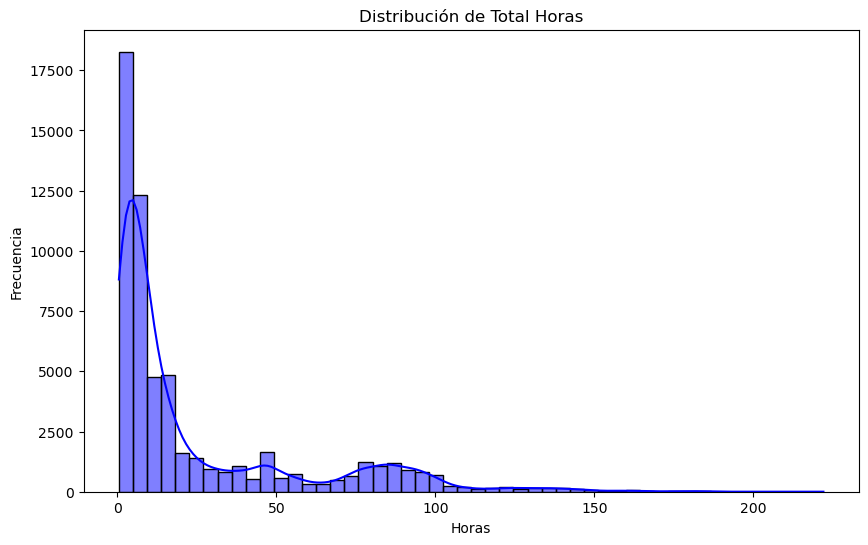

In [15]:
# Histograma de Total Horas
plt.figure(figsize=(10, 6))
sns.histplot(df2["Total_Horas"],bins=50,  kde=True, color="blue")
plt.title("Distribución de Total Horas")
plt.xlabel("Horas")
plt.ylabel("Frecuencia")
plt.show()



C:\Users\Juliana\AppData\Local\Temp\ipykernel_17232\2822883660.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2["Periodo"] = df2["Periodo"].str.strip().str.title()
C:\Users\Juliana\AppData\Local\Temp\ipykernel_17232\2822883660.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2["Periodo"] = df2["Periodo"].replace(meses_esp_a_eng, regex=True)
C:\Users\Juliana\AppData\Local\Temp\ipykernel_17232\2822883660.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataF

['April 2013' 'April 2014' 'April 2015' 'April 2016' 'April 2017'
 'April 2018' 'April 2019' 'April 2020' 'April 2021' 'August 2013'
 'August 2014' 'August 2015' 'August 2016' 'August 2017' 'August 2018'
 'August 2019' 'August 2020' 'August 2021' 'December 2013' 'December 2014'
 'December 2015' 'December 2016' 'December 2017' 'December 2018'
 'December 2019' 'December 2020' 'December 2021' 'January 2013'
 'January 2014' 'January 2015' 'January 2016' 'January 2017'
 'January 2018' 'January 2019' 'January 2020' 'January 2021'
 'February 2013' 'February 2014' 'February 2015' 'February 2016'
 'February 2017' 'February 2018' 'February 2019' 'February 2020'
 'February 2021' 'July 2013' 'July 2014' 'July 2015' 'July 2016'
 'July 2017' 'July 2018' 'July 2019' 'July 2020' 'July 2021' 'June 2013'
 'June 2014' 'June 2015' 'June 2016' 'June 2017' 'June 2018' 'June 2019'
 'June 2020' 'June 2021' 'March 2013' 'March 2014' 'March 2015'
 'March 2016' 'March 2017' 'March 2018' 'March 2019' 'March 2020'

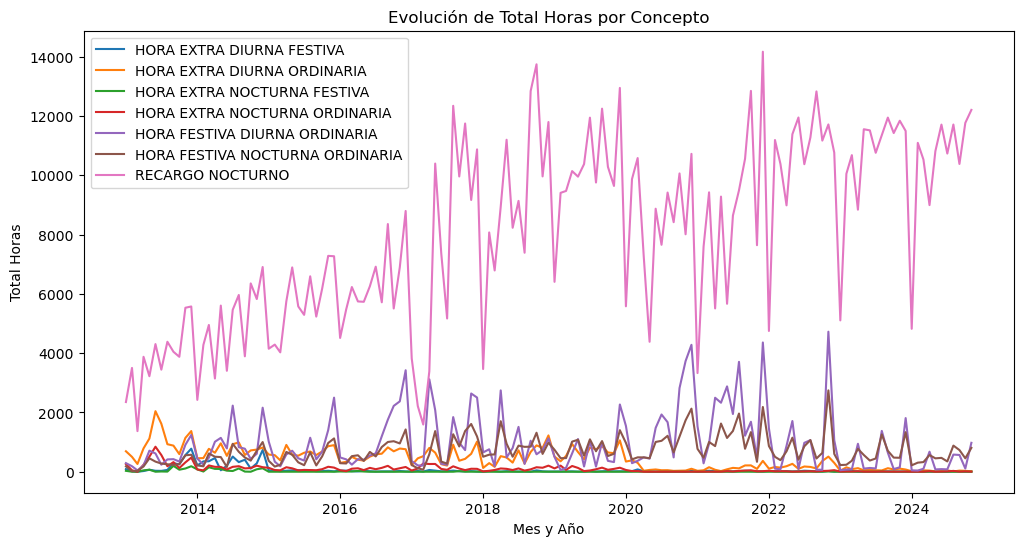

In [16]:

# Diccionario para convertir los nombres de los meses en español a inglés
meses_esp_a_eng = {
    'Enero': 'January', 'Febrero': 'February', 'Marzo': 'March', 'Abril': 'April', 'Mayo': 'May', 'Junio': 'June',
    'Julio': 'July', 'Agosto': 'August', 'Septiembre': 'September', 'Octubre': 'October', 'Noviembre': 'November', 'Diciembre': 'December'
}

# Limpiar la columna 'Periodo' (eliminando espacios innecesarios y normalizando la capitalización)
df2["Periodo"] = df2["Periodo"].str.strip().str.title()

# Reemplazar los nombres de los meses en español por los de inglés
df2["Periodo"] = df2["Periodo"].replace(meses_esp_a_eng, regex=True)

# Verificar que los valores sean correctos después del reemplazo
print(df2["Periodo"].unique())

# Convertir la columna 'Periodo' (ahora con los nombres de los meses en inglés) a formato de fecha
df2["Periodo"] = pd.to_datetime(df2["Periodo"], format="%B %Y", errors='coerce')

# Verificar si hay valores nulos después de la conversión
print(df2[df2["Periodo"].isna()])

# Convertir a periodo mensual
df2["Periodo"] = df2["Periodo"].dt.to_period("M")

# Agregar valores mensuales por concepto
temporal = df2.groupby(["Periodo", "Concepto"])[["Valor_Total", "Total_Horas"]].sum().reset_index()

# Serie temporal de Total Horas por Concepto
plt.figure(figsize=(12, 6))
for concepto in temporal["Concepto"].unique():
    datos = temporal[temporal["Concepto"] == concepto]
    plt.plot(datos["Periodo"].dt.to_timestamp(), datos["Total_Horas"], label=concepto)

plt.title("Evolución de Total Horas por Concepto")
plt.xlabel("Mes y Año")
plt.ylabel("Total Horas")
plt.legend()
plt.show()


C:\Users\Juliana\AppData\Local\Temp\ipykernel_17232\2036379298.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temporal = temporal_grupo.groupby(["Periodo", "Concepto"])[["Valor_Total", "Total_Horas"]].sum().reset_index()


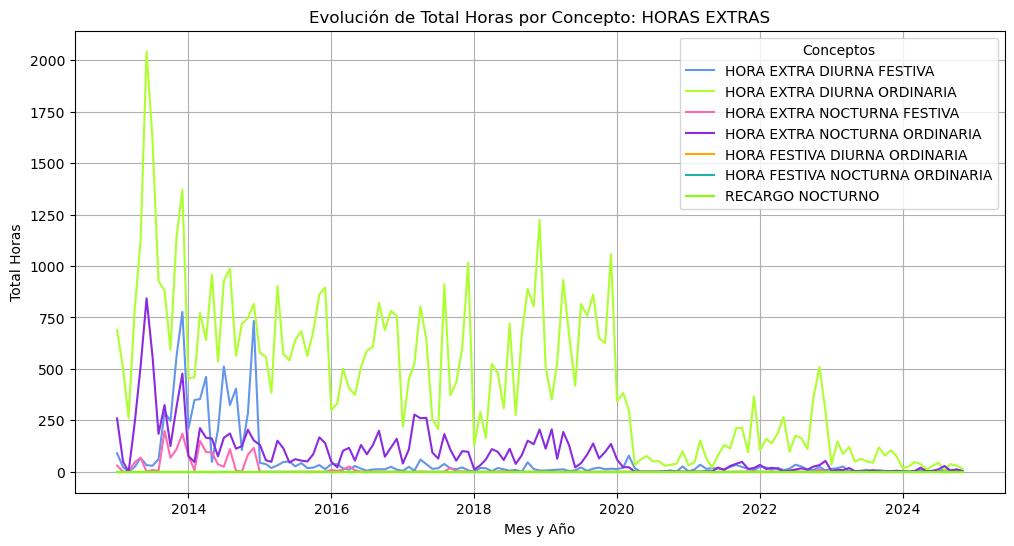

C:\Users\Juliana\AppData\Local\Temp\ipykernel_17232\2036379298.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temporal = temporal_grupo.groupby(["Periodo", "Concepto"])[["Valor_Total", "Total_Horas"]].sum().reset_index()


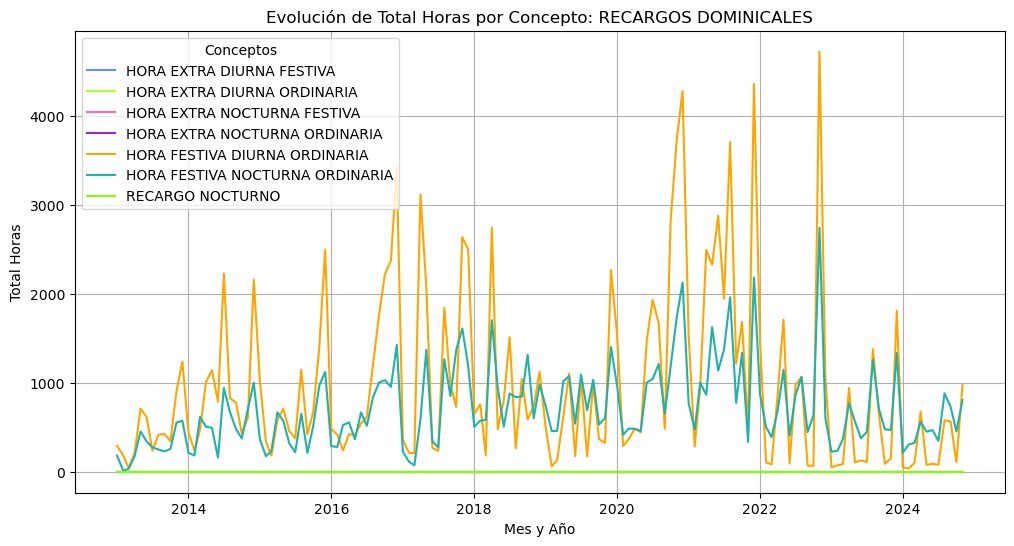

C:\Users\Juliana\AppData\Local\Temp\ipykernel_17232\2036379298.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temporal = temporal_grupo.groupby(["Periodo", "Concepto"])[["Valor_Total", "Total_Horas"]].sum().reset_index()


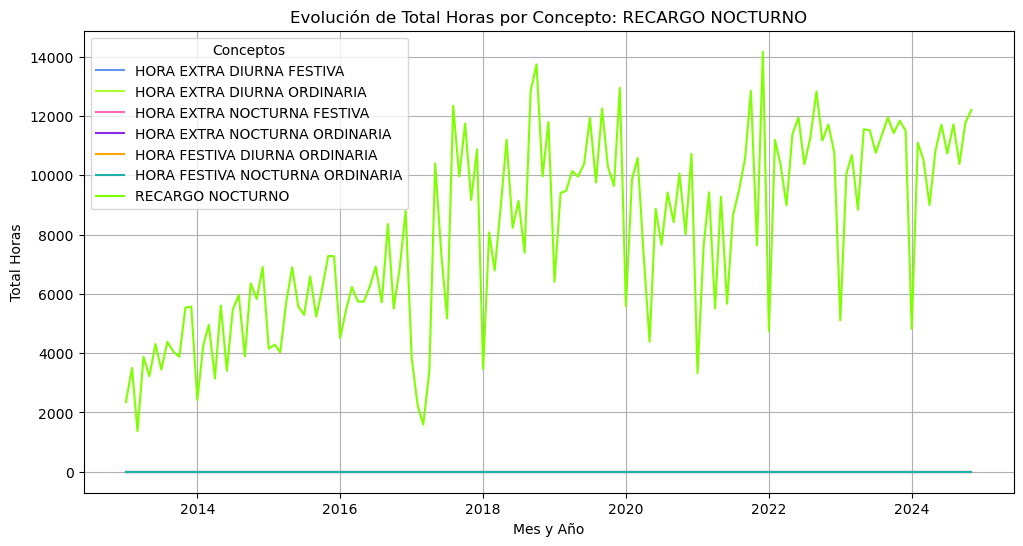

In [17]:
# Definir los grupos de conceptos
grupos_conceptos = {
    "HORAS EXTRAS": ['HORA EXTRA DIURNA FESTIVA', 'HORA EXTRA DIURNA ORDINARIA', 
                     'HORA EXTRA NOCTURNA FESTIVA', 'HORA EXTRA NOCTURNA ORDINARIA'],
    "RECARGOS DOMINICALES": ['HORA FESTIVA DIURNA ORDINARIA', 'HORA FESTIVA NOCTURNA ORDINARIA'],
    "RECARGO NOCTURNO": ['RECARGO NOCTURNO']
}

# Asignar colores a cada concepto
colores_conceptos = {
    'HORA EXTRA DIURNA FESTIVA': 'cornflowerblue',
    'HORA EXTRA DIURNA ORDINARIA': 'greenyellow',
    'HORA EXTRA NOCTURNA FESTIVA': 'hotpink',
    'HORA EXTRA NOCTURNA ORDINARIA': 'blueviolet',
    'HORA FESTIVA DIURNA ORDINARIA': 'orange',
    'HORA FESTIVA NOCTURNA ORDINARIA': 'lightseagreen',
    'RECARGO NOCTURNO': 'chartreuse'
}


# Crear una figura para cada grupo de conceptos
for grupo, conceptos in grupos_conceptos.items():
    # Filtrar los datos para el grupo actual
    temporal_grupo = df2[df2["Concepto"].isin(conceptos)]
    
    # Agregar valores mensuales por concepto dentro del grupo
    temporal = temporal_grupo.groupby(["Periodo", "Concepto"])[["Valor_Total", "Total_Horas"]].sum().reset_index()

    # Crear una nueva figura para cada grupo
    plt.figure(figsize=(12, 6))
    
    # Graficar los datos de cada concepto dentro del grupo
    for concepto in temporal["Concepto"].unique():
        datos = temporal[temporal["Concepto"] == concepto]
        plt.plot(
            datos["Periodo"].dt.to_timestamp(), 
            datos["Total_Horas"], 
            label=concepto, 
            color=colores_conceptos.get(concepto, 'black')
        )

    # Títulos, etiquetas y leyenda
    plt.title(f"Evolución de Total Horas por Concepto: {grupo}")
    plt.xlabel("Mes y Año")
    plt.ylabel("Total Horas")
    plt.legend(title="Conceptos")
    plt.grid(True)
    plt.show()


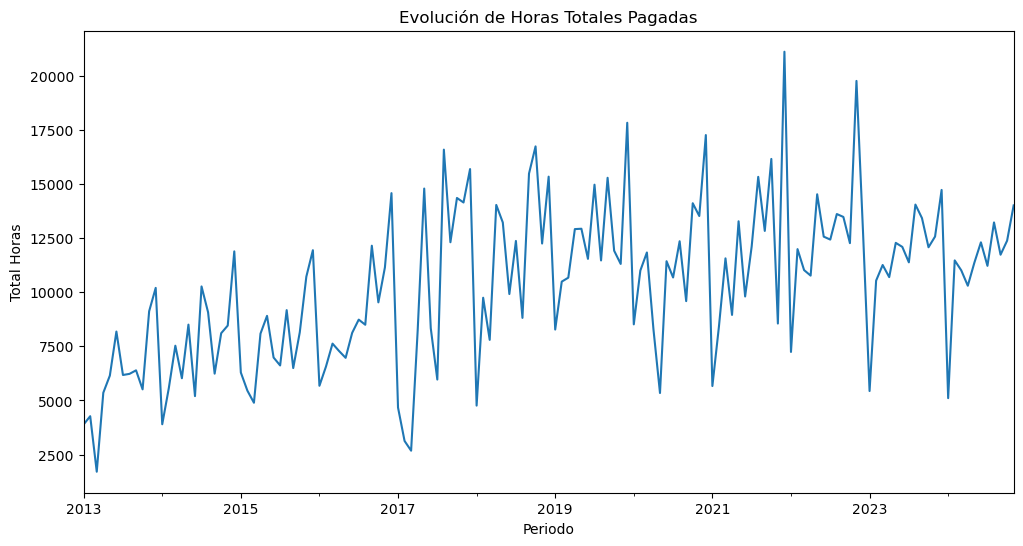

In [18]:
#Gracfica de horas totales
plt.figure(figsize=(12, 6))
df2.groupby('Periodo')['Total_Horas'].sum().plot(title='Evolución de Horas Totales Pagadas')
plt.ylabel('Total Horas')
plt.show()

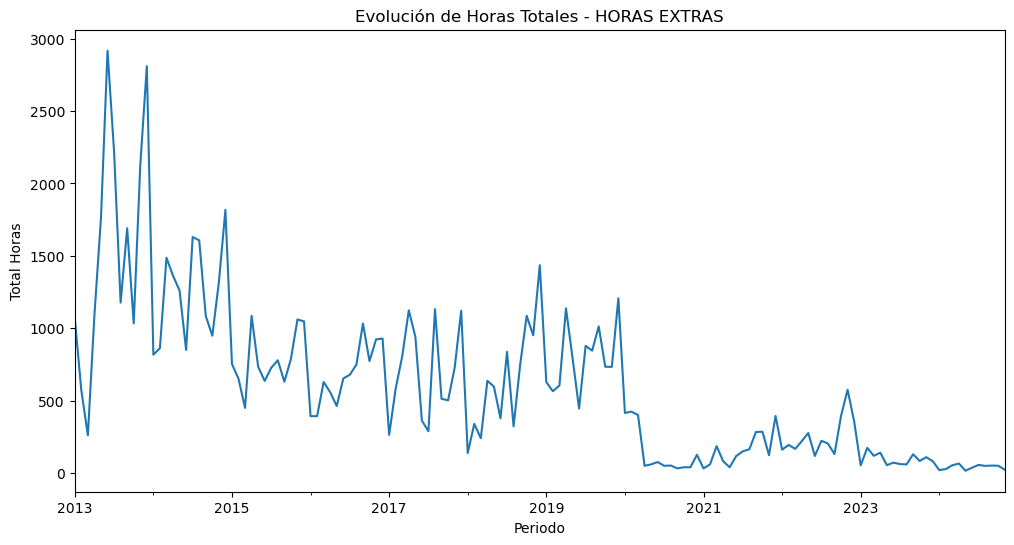

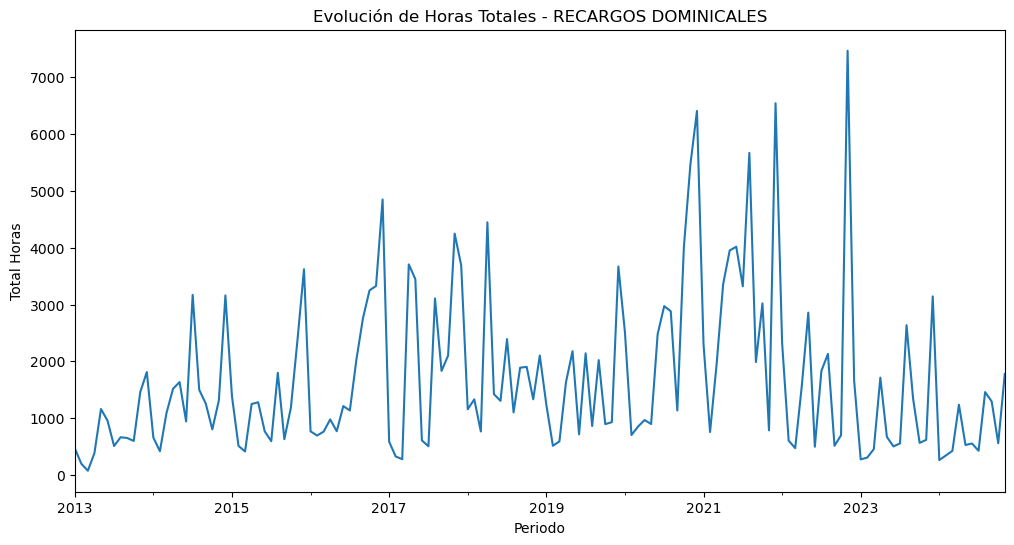

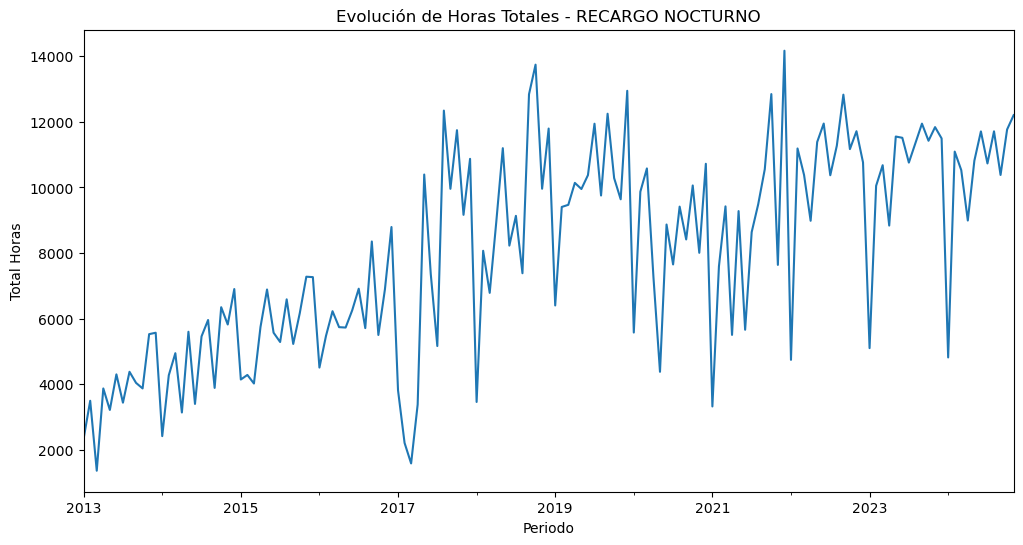

In [19]:
# Distribución por grupos de conceptos
grupos_conceptos = {
    "HORAS EXTRAS": ['HORA EXTRA DIURNA FESTIVA', 'HORA EXTRA DIURNA ORDINARIA', 
                     'HORA EXTRA NOCTURNA FESTIVA', 'HORA EXTRA NOCTURNA ORDINARIA'],
    "RECARGOS DOMINICALES": ['HORA FESTIVA DIURNA ORDINARIA', 'HORA FESTIVA NOCTURNA ORDINARIA'],
    "RECARGO NOCTURNO": ['RECARGO NOCTURNO']
}

for grupo, conceptos in grupos_conceptos.items():
    df_grupo = df2[df2['Concepto'].isin(conceptos)]
    plt.figure(figsize=(12, 6))
    df_grupo.groupby('Periodo')['Total_Horas'].sum().plot(title=f'Evolución de Horas Totales - {grupo}')
    plt.ylabel('Total Horas')
    plt.show()

Datos filtrados para HORAS EXTRAS:
                      Concepto     Centro_Costos  Total_Horas  Valor_Total
0  HORA EXTRA DIURNA ORDINARIA           Liquids         17.0        90131
1  HORA EXTRA NOCTURNA FESTIVA           Liquids          6.0        63622
4  HORA EXTRA DIURNA ORDINARIA           Liquids         13.0        67947
7  HORA EXTRA DIURNA ORDINARIA  Solid Production         33.0       197499
8  HORA EXTRA DIURNA ORDINARIA       Maintenance          3.0        26095


C:\Users\Juliana\AppData\Local\Temp\ipykernel_17232\2216606611.py:11: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  heatmap_data_horas = df_filtrado.pivot_table(index="Centro_Costos", columns="Concepto", values="Total_Horas", aggfunc="sum")


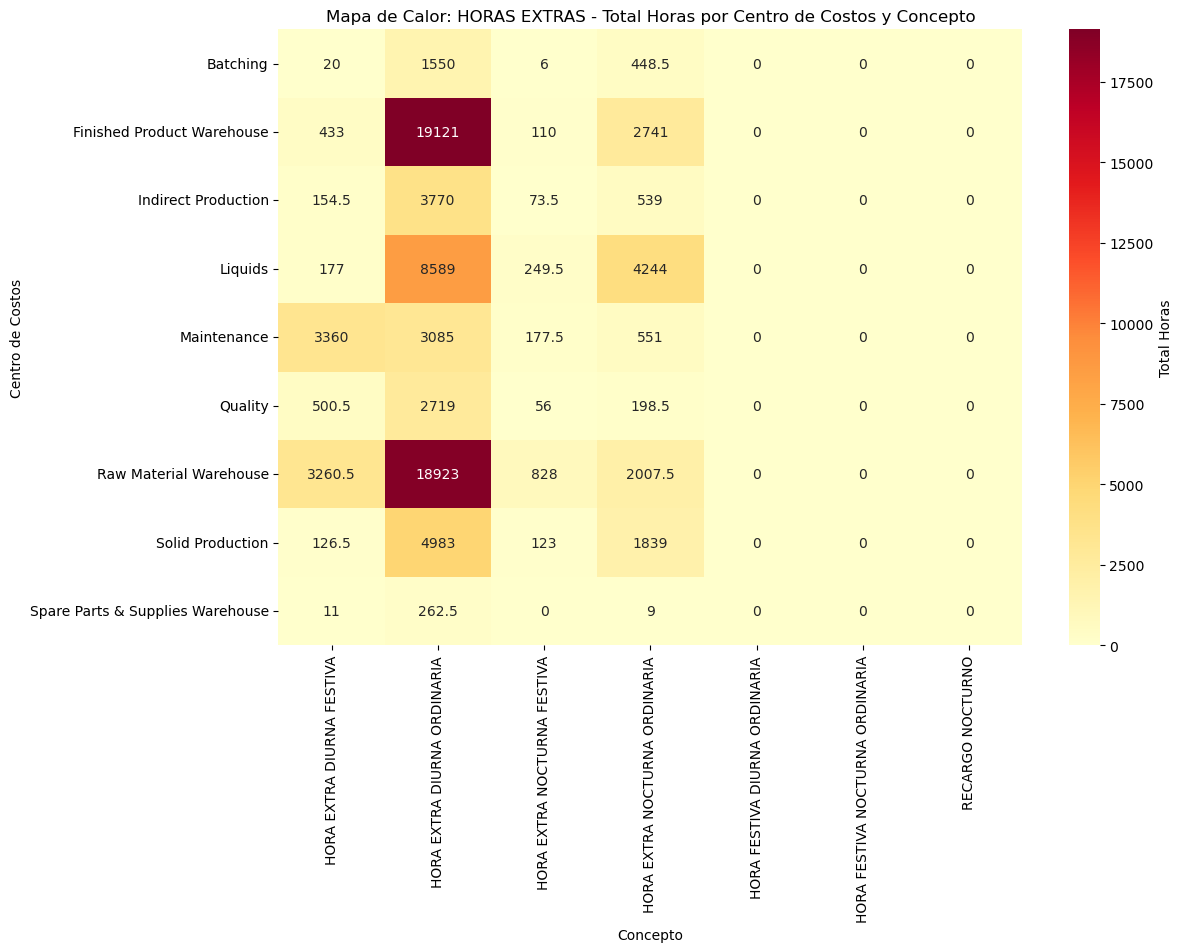

Datos filtrados para RECARGOS DOMINICALES:
                           Concepto        Centro_Costos  Total_Horas  \
2   HORA FESTIVA NOCTURNA ORDINARIA              Liquids          2.0   
5   HORA FESTIVA NOCTURNA ORDINARIA              Liquids          2.0   
10    HORA FESTIVA DIURNA ORDINARIA          Maintenance         16.0   
13  HORA FESTIVA NOCTURNA ORDINARIA  Indirect Production          2.0   
17    HORA FESTIVA DIURNA ORDINARIA  Indirect Production          9.0   

    Valor_Total  
2         17814  
5         17814  
10       194842  
13        17814  
17        66803  


C:\Users\Juliana\AppData\Local\Temp\ipykernel_17232\2216606611.py:11: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  heatmap_data_horas = df_filtrado.pivot_table(index="Centro_Costos", columns="Concepto", values="Total_Horas", aggfunc="sum")


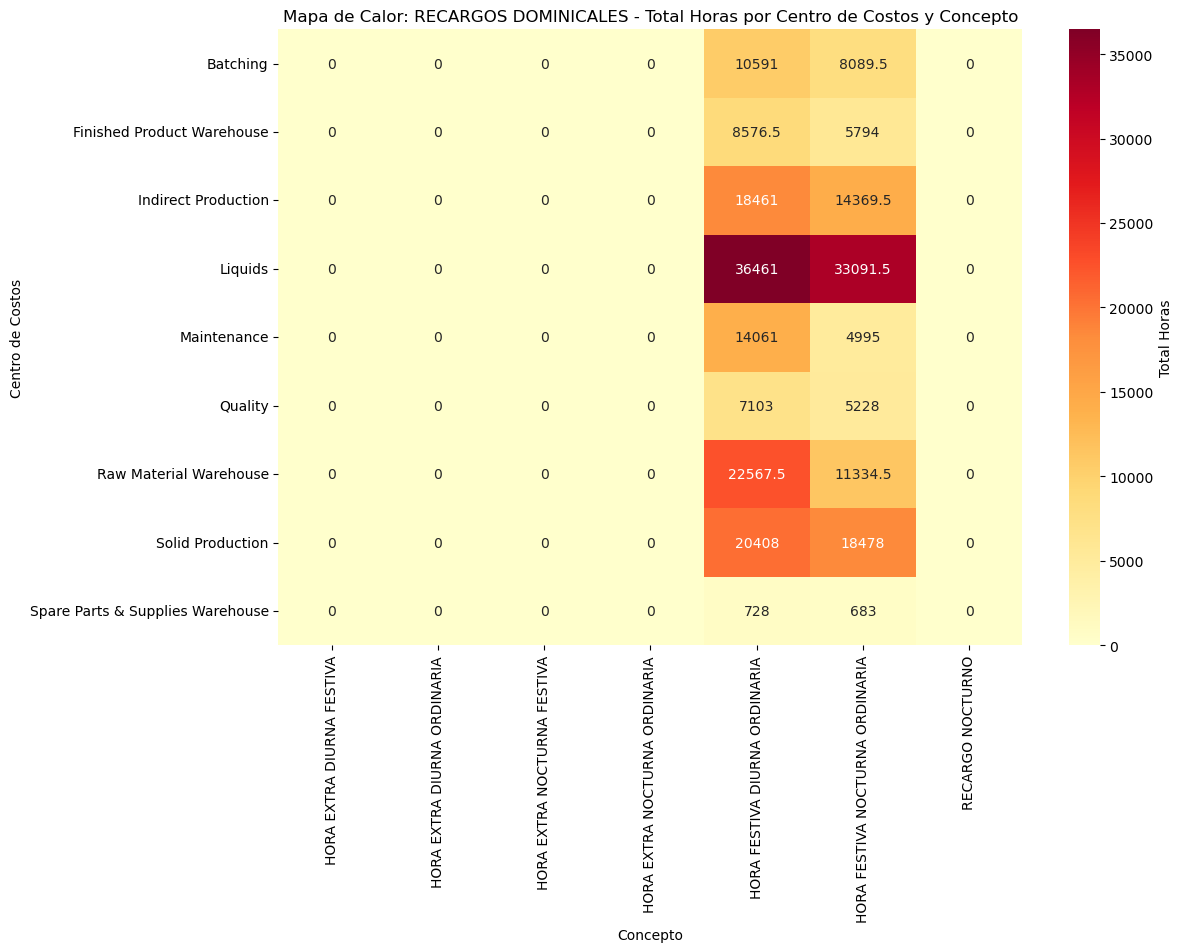

Datos filtrados para RECARGO NOCTURNO:
            Concepto               Centro_Costos  Total_Horas  Valor_Total
3   RECARGO NOCTURNO                     Liquids         88.0       130637
6   RECARGO NOCTURNO                     Liquids          6.0         8907
14  RECARGO NOCTURNO         Indirect Production        137.0       203377
26  RECARGO NOCTURNO  Finished Product Warehouse        122.0       186661
29  RECARGO NOCTURNO                     Liquids         28.0        39029


C:\Users\Juliana\AppData\Local\Temp\ipykernel_17232\2216606611.py:11: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  heatmap_data_horas = df_filtrado.pivot_table(index="Centro_Costos", columns="Concepto", values="Total_Horas", aggfunc="sum")


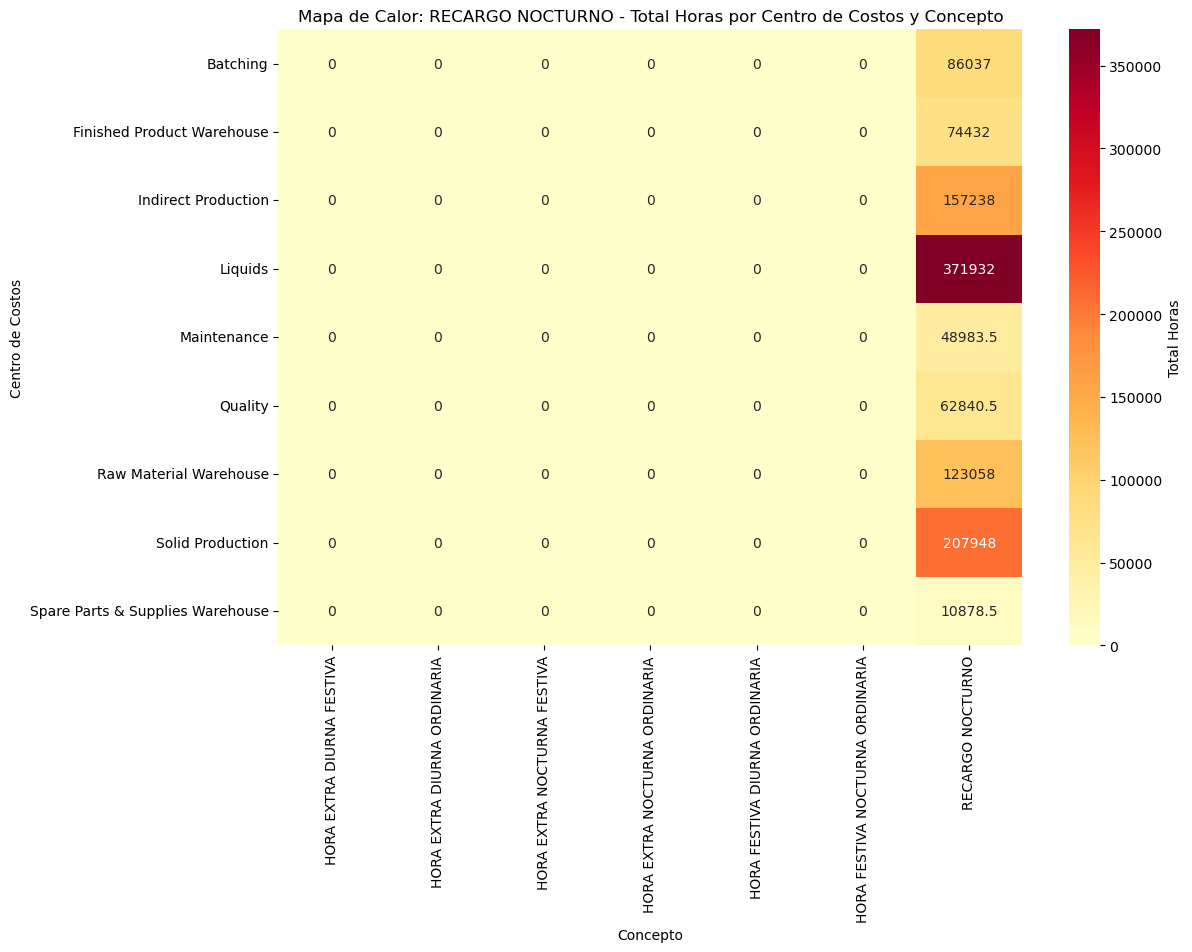

In [20]:
# Función para generar mapas de calor por grupo
def generar_heatmap_por_grupo(grupo_nombre, conceptos_del_grupo):
    # Filtrar los datos del grupo de acuerdo a los conceptos
    df_filtrado = df2[df2["Concepto"].isin(conceptos_del_grupo)].copy()

    # Asegurarnos de que solo tenemos los conceptos del grupo en el dataframe filtrado
    print(f"Datos filtrados para {grupo_nombre}:")
    print(df_filtrado[["Concepto", "Centro_Costos", "Total_Horas", "Valor_Total"]].head())
    
    # Crear la tabla pivot solo con los conceptos del grupo (para Total Horas)
    heatmap_data_horas = df_filtrado.pivot_table(index="Centro_Costos", columns="Concepto", values="Total_Horas", aggfunc="sum")
    
    # Crear el mapa de calor para Total Horas
    plt.figure(figsize=(12, 8))
    sns.heatmap(heatmap_data_horas, annot=True, cmap="YlOrRd", fmt="g", cbar_kws={'label': 'Total Horas'})
    plt.title(f"Mapa de Calor: {grupo_nombre} - Total Horas por Centro de Costos y Concepto")
    plt.xlabel("Concepto")
    plt.ylabel("Centro de Costos")
    plt.show()



# Generar mapas de calor para cada grupo
for grupo_nombre, conceptos_del_grupo in grupos_conceptos.items():
    generar_heatmap_por_grupo(grupo_nombre, conceptos_del_grupo)

In [21]:
# Crear un mapeo de los meses en español
meses_map = {
    "Enero": "01", "Febrero": "02", "Marzo": "03", "Abril": "04",
    "Mayo": "05", "Junio": "06", "Julio": "07", "Agosto": "08",
    "Septiembre": "09", "Octubre": "10", "Noviembre": "11", "Diciembre": "12"
}

# Mapear el mes de la columna 'Mes' a su equivalente numérico
df2['Mes_num'] = df2['Mes'].map(meses_map)

# Crear la columna de fecha en formato 'YYYY-MM-DD' usando Año, Mes_num y el día '01'
df2['Fecha'] = pd.to_datetime(df2['Año'].astype(str) + '-' + df2['Mes_num'] + '-01', format='%Y-%m-%d')

# Mostrar el resultado
df2.head()

C:\Users\Juliana\AppData\Local\Temp\ipykernel_17232\172368562.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['Mes_num'] = df2['Mes'].map(meses_map)
C:\Users\Juliana\AppData\Local\Temp\ipykernel_17232\172368562.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['Fecha'] = pd.to_datetime(df2['Año'].astype(str) + '-' + df2['Mes_num'] + '-01', format='%Y-%m-%d')


,Empleado_ID,Centro_Costos,Valor_Total,Total_Horas,Concepto,Periodo,Mes,Año,Mes_num,Fecha
0,124a0137311e6f534f05ac65d09e54f0b0d67c8f0b2b06...,Liquids,90131,17.0,HORA EXTRA DIURNA ORDINARIA,2013-04,Abril,2013,04,2013-04-01
1,124a0137311e6f534f05ac65d09e54f0b0d67c8f0b2b06...,Liquids,63622,6.0,HORA EXTRA NOCTURNA FESTIVA,2013-04,Abril,2013,04,2013-04-01
2,124a0137311e6f534f05ac65d09e54f0b0d67c8f0b2b06...,Liquids,17814,2.0,HORA FESTIVA NOCTURNA ORDINARIA,2013-04,Abril,2013,04,2013-04-01
3,124a0137311e6f534f05ac65d09e54f0b0d67c8f0b2b06...,Liquids,130637,88.0,RECARGO NOCTURNO,2013-04,Abril,2013,04,2013-04-01
4,481c4860f4c8894808c45980d7126b27fff161860ea69d...,Liquids,67947,13.0,HORA EXTRA DIURNA ORDINARIA,2013-04,Abril,2013,04,2013-04-01


C:\Users\Juliana\AppData\Local\Temp\ipykernel_17232\3683326091.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['Fecha'] = pd.to_datetime(df2['Fecha'])
C:\Users\Juliana\AppData\Local\Temp\ipykernel_17232\3683326091.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['mes_anio'] = df2['Fecha'].dt.to_period('M')  # 'M' para Año-Mes


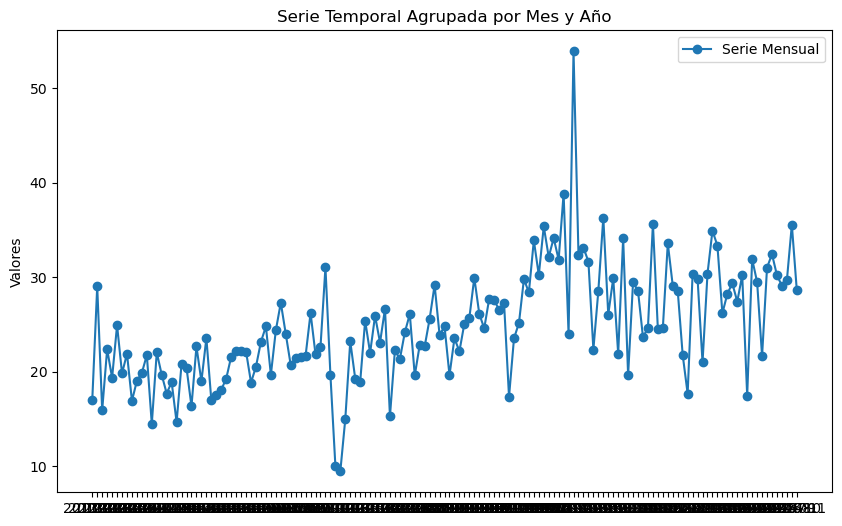

In [22]:
# Confirmamos que las fechas estén en formato datetime
df2['Fecha'] = pd.to_datetime(df2['Fecha'])

# Creamos una nueva columna con solo el año y el mes con el formato indicado
df2['mes_anio'] = df2['Fecha'].dt.to_period('M')  # 'M' para Año-Mes

# Definimos la serie
df3 = df2.groupby('mes_anio')['Total_Horas'].mean().reset_index()

# Graficar la serie usando Año-Mes
plt.figure(figsize=(10, 6))
plt.plot(df3['mes_anio'].astype(str), df3['Total_Horas'], marker='o', label='Serie Mensual')
plt.title('Serie Temporal Agrupada por Mes y Año')
plt.ylabel('Valores')
plt.legend()
plt.show()

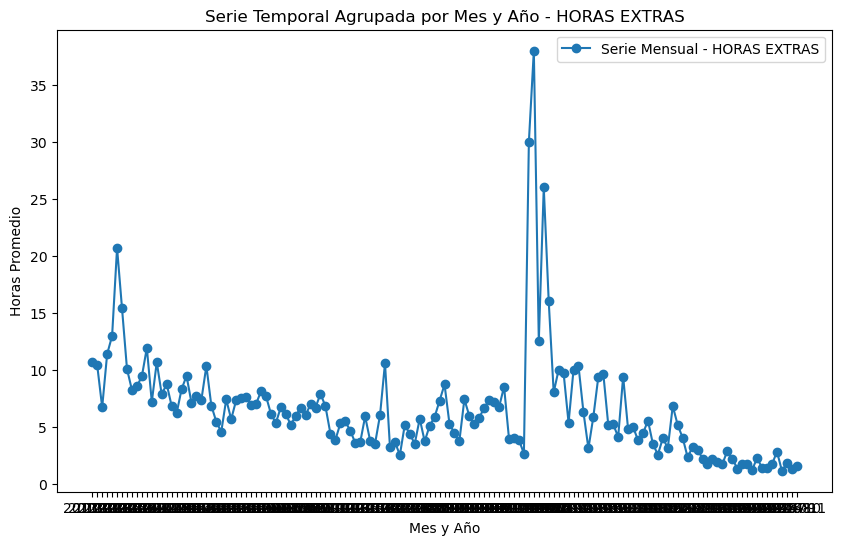

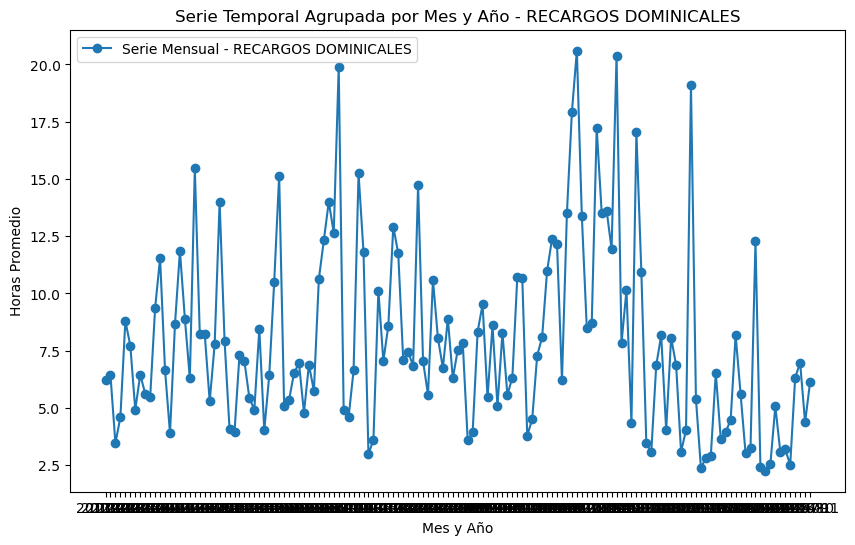

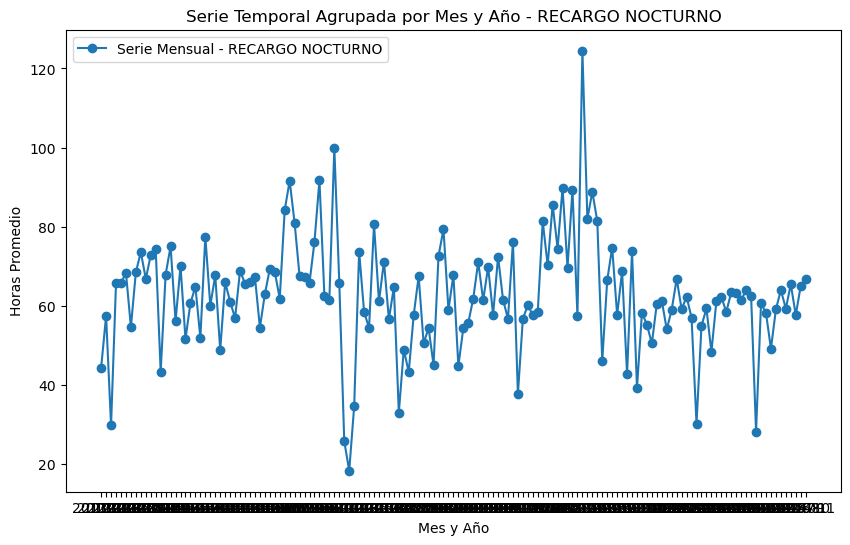

In [23]:
# Graficar para cada grupo
for grupo, conceptos in grupos_conceptos.items():
    # Filtrar datos para el grupo actual
    df_grupo = df2[df2['Concepto'].isin(conceptos)]

    # Agrupar los datos por mes y año
    df_agrupado = df_grupo.groupby('mes_anio')['Total_Horas'].mean().reset_index()

    # Graficar la serie temporal
    plt.figure(figsize=(10, 6))
    plt.plot(df_agrupado['mes_anio'].astype(str), df_agrupado['Total_Horas'], marker='o', label=f'Serie Mensual - {grupo}')
    plt.title(f'Serie Temporal Agrupada por Mes y Año - {grupo}')
    plt.xlabel('Mes y Año')
    plt.ylabel('Horas Promedio')
    plt.legend()
    plt.show()

### Inclusión de novedades de ausentismo

In [24]:
# Ajustar todas las fechas al primer día del mes
def ajustar_fechas(df, fecha_col):
    df2[fecha_col] = pd.to_datetime(df2[fecha_col]).dt.to_period('M').dt.to_timestamp()
    return df

In [25]:
import pandas as pd
from holidays import Colombia

# ==========================
# Paso 1: Generar días festivos por mes
# ==========================
def generar_festivos_por_mes():
    festivos = Colombia(years=range(2013, 2025))
    rango_fechas = pd.date_range(start='2013-01-01', end='2024-12-31')
    festivos_df = pd.DataFrame({'Fecha': rango_fechas})
    festivos_df['EsFestivo'] = festivos_df['Fecha'].apply(lambda x: 1 if x in festivos else 0)
    festivos_df['Mes'] = festivos_df['Fecha'].dt.to_period('M')
    dias_festivos_por_mes = festivos_df.groupby('Mes')['EsFestivo'].sum().reset_index()
    dias_festivos_por_mes.rename(columns={'EsFestivo': 'DiasFestivos'}, inplace=True)
    dias_festivos_por_mes['Fecha'] = dias_festivos_por_mes['Mes'].dt.to_timestamp()
    return dias_festivos_por_mes

# Generar los días festivos por mes
dias_festivos_por_mes = generar_festivos_por_mes()

# ==========================
# Paso 2: Leer novedades de ausentismo y agrupar por mes
# ==========================
novedades = pd.read_excel('Novedades de ausentismo 2013 - 2024.xlsx')
novedades['Fecha_Inicio'] = pd.to_datetime(novedades['Fecha_Inicio'], errors='coerce')
novedades['Fecha_Fin'] = pd.to_datetime(novedades['Fecha_Fin'], errors='coerce')
novedades = novedades.dropna(subset=['Fecha_Inicio', 'Fecha_Fin'])

novedades_expandido = pd.concat([
    pd.DataFrame({'Fecha': pd.date_range(row['Fecha_Inicio'], row['Fecha_Fin'], freq='D')})
    for _, row in novedades.iterrows()
], ignore_index=True)

novedades_expandido['Mes'] = novedades_expandido['Fecha'].dt.to_period('M')
novedades_por_mes = (
    novedades_expandido.groupby('Mes').size()
    .reset_index(name='Dias_Novedades')
)
novedades_por_mes['Fecha'] = novedades_por_mes['Mes'].dt.to_timestamp()

# ==========================
# Paso 3: Ajustar las fechas en df2
# ==========================
df2['Fecha'] = pd.to_datetime(df2['Fecha'], errors='coerce')
df2['Mes'] = df2['Fecha'].dt.to_period('M')

# Agrupar métricas de df2 a nivel mensual
df_mensual = df2.groupby('Mes').agg({
    'Total_Horas': 'sum',  # Sumar horas totales del mes
    'Valor_Total': 'sum',  # Sumar valor total del mes
}).reset_index()

# ==========================
# Paso 4: Fusionar festivos y novedades con el DataFrame mensual
# ==========================
# Fusionar días festivos con df_mensual
df_mensual = pd.merge(df_mensual, dias_festivos_por_mes[['Mes', 'DiasFestivos']], on='Mes', how='left')

# Fusionar novedades con df_mensual
df_mensual = pd.merge(df_mensual, novedades_por_mes[['Mes', 'Dias_Novedades']], on='Mes', how='left')

# Rellenar valores faltantes con 0
df_mensual['DiasFestivos'] = df_mensual['DiasFestivos'].fillna(0)
df_mensual['Dias_Novedades'] = df_mensual['Dias_Novedades'].fillna(0)

# ==========================
# Paso 5: Verificar resultados
# ==========================
print("DataFrame mensual consolidado:")
print(df_mensual.head())


DataFrame mensual consolidado:
       Mes  Total_Horas  Valor_Total  DiasFestivos  Dias_Novedades
0  2013-01       3891.0     15948096             2             284
1  2013-02       4270.0     11484820             0             308
2  2013-03       1706.0      4738123             3             935
3  2013-04       5353.0     17643872             0             331
4  2013-05       6145.0     28378021             2             301


C:\Users\Juliana\AppData\Local\Temp\ipykernel_17232\1757646219.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['Fecha'] = pd.to_datetime(df2['Fecha'], errors='coerce')
C:\Users\Juliana\AppData\Local\Temp\ipykernel_17232\1757646219.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['Mes'] = df2['Fecha'].dt.to_period('M')


In [26]:
# Crear resumen mensual para festivos y novedades
resumen_mensual = df_mensual[['Mes', 'DiasFestivos', 'Dias_Novedades']].copy()

# Verificar resumen mensual
print("Resumen mensual (festivos y novedades):")
print(resumen_mensual.head())


Resumen mensual (festivos y novedades):
       Mes  DiasFestivos  Dias_Novedades
0  2013-01             2             284
1  2013-02             0             308
2  2013-03             3             935
3  2013-04             0             331
4  2013-05             2             301


In [27]:
df2.head()

,Empleado_ID,Centro_Costos,Valor_Total,Total_Horas,Concepto,Periodo,Mes,Año,Mes_num,Fecha,mes_anio
0,124a0137311e6f534f05ac65d09e54f0b0d67c8f0b2b06...,Liquids,90131,17.0,HORA EXTRA DIURNA ORDINARIA,2013-04,2013-04,2013,04,2013-04-01,2013-04
1,124a0137311e6f534f05ac65d09e54f0b0d67c8f0b2b06...,Liquids,63622,6.0,HORA EXTRA NOCTURNA FESTIVA,2013-04,2013-04,2013,04,2013-04-01,2013-04
2,124a0137311e6f534f05ac65d09e54f0b0d67c8f0b2b06...,Liquids,17814,2.0,HORA FESTIVA NOCTURNA ORDINARIA,2013-04,2013-04,2013,04,2013-04-01,2013-04
3,124a0137311e6f534f05ac65d09e54f0b0d67c8f0b2b06...,Liquids,130637,88.0,RECARGO NOCTURNO,2013-04,2013-04,2013,04,2013-04-01,2013-04
4,481c4860f4c8894808c45980d7126b27fff161860ea69d...,Liquids,67947,13.0,HORA EXTRA DIURNA ORDINARIA,2013-04,2013-04,2013,04,2013-04-01,2013-04


### Modelos

In [28]:
# Convertir 'Mes' en df2 y df_mensual al formato datetime64[ns]
df2['Mes'] = pd.to_datetime(df2['Mes'], errors='coerce')
df_mensual['Mes'] = pd.to_datetime(df_mensual['Mes'].dt.to_timestamp(), errors='coerce')


C:\Users\Juliana\AppData\Local\Temp\ipykernel_17232\2429791733.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['Mes'] = pd.to_datetime(df2['Mes'], errors='coerce')


In [29]:
df_mensual.head()

,Mes,Total_Horas,Valor_Total,DiasFestivos,Dias_Novedades
0,2013-01-01,3891.0,15948096,2,284
1,2013-02-01,4270.0,11484820,0,308
2,2013-03-01,1706.0,4738123,3,935
3,2013-04-01,5353.0,17643872,0,331
4,2013-05-01,6145.0,28378021,2,301


In [30]:
print("Primeras filas de df2:")
print(df2.head())

print("Conceptos únicos en df2:")
print(df2['Concepto'].unique())

print("Tamaño de df2:", df2.shape)


Primeras filas de df2:
                                         Empleado_ID Centro_Costos  \
0  124a0137311e6f534f05ac65d09e54f0b0d67c8f0b2b06...       Liquids   
1  124a0137311e6f534f05ac65d09e54f0b0d67c8f0b2b06...       Liquids   
2  124a0137311e6f534f05ac65d09e54f0b0d67c8f0b2b06...       Liquids   
3  124a0137311e6f534f05ac65d09e54f0b0d67c8f0b2b06...       Liquids   
4  481c4860f4c8894808c45980d7126b27fff161860ea69d...       Liquids   

   Valor_Total  Total_Horas                         Concepto  Periodo Mes  \
0        90131         17.0      HORA EXTRA DIURNA ORDINARIA  2013-04 NaT   
1        63622          6.0      HORA EXTRA NOCTURNA FESTIVA  2013-04 NaT   
2        17814          2.0  HORA FESTIVA NOCTURNA ORDINARIA  2013-04 NaT   
3       130637         88.0                 RECARGO NOCTURNO  2013-04 NaT   
4        67947         13.0      HORA EXTRA DIURNA ORDINARIA  2013-04 NaT   

    Año Mes_num      Fecha mes_anio  
0  2013      04 2013-04-01  2013-04  
1  2013      04 2

In [31]:
print("Primeras filas de df_mensual:")
print(df_mensual.head())

print("Tamaño de df_mensual:", df_mensual.shape)


Primeras filas de df_mensual:
         Mes  Total_Horas  Valor_Total  DiasFestivos  Dias_Novedades
0 2013-01-01       3891.0     15948096             2             284
1 2013-02-01       4270.0     11484820             0             308
2 2013-03-01       1706.0      4738123             3             935
3 2013-04-01       5353.0     17643872             0             331
4 2013-05-01       6145.0     28378021             2             301
Tamaño de df_mensual: (143, 5)


In [32]:
# Asegurar que las columnas 'Mes' estén en formato datetime
df2['Fecha'] = pd.to_datetime(df2['Fecha'], errors='coerce')
df_mensual['Mes'] = pd.to_datetime(df_mensual['Mes'], errors='coerce')

# Confirmar los tipos de datos después de la conversión
print("Tipos de datos después de la conversión:")
print(f"Tipo de 'Mes' en df2: {df2['Fecha'].dtype}")
print(f"Tipo de 'Mes' en df_mensual: {df_mensual['Mes'].dtype}")

# Mostrar valores únicos para validar
print("Valores únicos en 'Mes' de df2:")
print(df2['Fecha'].unique())
print("Valores únicos en 'Mes' de df_mensual:")
print(df_mensual['Mes'].unique())


Tipos de datos después de la conversión:
Tipo de 'Mes' en df2: datetime64[ns]
Tipo de 'Mes' en df_mensual: datetime64[ns]
Valores únicos en 'Mes' de df2:
<DatetimeArray>
['2013-04-01 00:00:00', '2014-04-01 00:00:00', '2015-04-01 00:00:00',
 '2016-04-01 00:00:00', '2017-04-01 00:00:00', '2018-04-01 00:00:00',
 '2019-04-01 00:00:00', '2020-04-01 00:00:00', '2021-04-01 00:00:00',
 '2013-08-01 00:00:00',
 ...
 '2024-11-01 00:00:00', '2024-09-01 00:00:00', '2024-04-01 00:00:00',
 '2024-01-01 00:00:00', '2024-02-01 00:00:00', '2024-07-01 00:00:00',
 '2024-06-01 00:00:00', '2024-05-01 00:00:00', '2024-10-01 00:00:00',
 '2024-03-01 00:00:00']
Length: 143, dtype: datetime64[ns]
Valores únicos en 'Mes' de df_mensual:
<DatetimeArray>
['2013-01-01 00:00:00', '2013-02-01 00:00:00', '2013-03-01 00:00:00',
 '2013-04-01 00:00:00', '2013-05-01 00:00:00', '2013-06-01 00:00:00',
 '2013-07-01 00:00:00', '2013-08-01 00:00:00', '2013-09-01 00:00:00',
 '2013-10-01 00:00:00',
 ...
 '2024-02-01 00:00:00', '202

C:\Users\Juliana\AppData\Local\Temp\ipykernel_17232\469352958.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['Fecha'] = pd.to_datetime(df2['Fecha'], errors='coerce')


In [33]:
df_mensual.head()

,Mes,Total_Horas,Valor_Total,DiasFestivos,Dias_Novedades
0,2013-01-01,3891.0,15948096,2,284
1,2013-02-01,4270.0,11484820,0,308
2,2013-03-01,1706.0,4738123,3,935
3,2013-04-01,5353.0,17643872,0,331
4,2013-05-01,6145.0,28378021,2,301


In [34]:
df2.head()

,Empleado_ID,Centro_Costos,Valor_Total,Total_Horas,Concepto,Periodo,Mes,Año,Mes_num,Fecha,mes_anio
0,124a0137311e6f534f05ac65d09e54f0b0d67c8f0b2b06...,Liquids,90131,17.0,HORA EXTRA DIURNA ORDINARIA,2013-04,NaT,2013,04,2013-04-01,2013-04
1,124a0137311e6f534f05ac65d09e54f0b0d67c8f0b2b06...,Liquids,63622,6.0,HORA EXTRA NOCTURNA FESTIVA,2013-04,NaT,2013,04,2013-04-01,2013-04
2,124a0137311e6f534f05ac65d09e54f0b0d67c8f0b2b06...,Liquids,17814,2.0,HORA FESTIVA NOCTURNA ORDINARIA,2013-04,NaT,2013,04,2013-04-01,2013-04
3,124a0137311e6f534f05ac65d09e54f0b0d67c8f0b2b06...,Liquids,130637,88.0,RECARGO NOCTURNO,2013-04,NaT,2013,04,2013-04-01,2013-04
4,481c4860f4c8894808c45980d7126b27fff161860ea69d...,Liquids,67947,13.0,HORA EXTRA DIURNA ORDINARIA,2013-04,NaT,2013,04,2013-04-01,2013-04


In [35]:
# Crear resumen mensual por concepto y consolidar con días festivos y novedades
def crear_resumen_mensual_por_concepto(df2, df_mensual, conceptos_relevantes):
    # Filtrar datos de los conceptos relevantes
    df2_filtrado = df2[df2['Concepto'].isin(conceptos_relevantes)]
    print("Tamaño de df2 después de filtrar:", df2_filtrado.shape)

    # Agrupar por Mes y Concepto para sumar Total_Horas
    resumen_por_concepto = (
        df2_filtrado.groupby(['Fecha', 'Concepto'])['Total_Horas']
        .sum()
        .unstack(fill_value=0)
        .reset_index()
    )
    print("Resumen por concepto después del agrupamiento:")
    print(resumen_por_concepto.head())

    # Renombrar 'Fecha' a 'Mes' para facilitar la unión con df_mensual
    resumen_por_concepto.rename(columns={'Fecha': 'Mes'}, inplace=True)

    # Unir con días festivos y novedades desde df_mensual
    resumen_mensual = pd.merge(
        resumen_por_concepto,
        df_mensual[['Mes', 'DiasFestivos', 'Dias_Novedades']],
        on='Mes',
        how='left'
    )

    print("Resumen mensual después de unir con df_mensual:")
    print(resumen_mensual.head())

    # Rellenar valores nulos en las columnas de festivos y novedades
    resumen_mensual['DiasFestivos'].fillna(0, inplace=True)
    resumen_mensual['Dias_Novedades'].fillna(0, inplace=True)

    # Asegurar que solo se mantengan las columnas relevantes
    columnas_relevantes = ['Mes', 'DiasFestivos', 'Dias_Novedades'] + conceptos_relevantes
    resumen_mensual = resumen_mensual[columnas_relevantes]

    return resumen_mensual

# Lista de conceptos relevantes
conceptos_relevantes = [
    'HORA EXTRA DIURNA FESTIVA',
    'HORA EXTRA DIURNA ORDINARIA',
    'HORA EXTRA NOCTURNA FESTIVA',
    'HORA EXTRA NOCTURNA ORDINARIA'
]

# Crear el resumen mensual consolidado
resumen_final = crear_resumen_mensual_por_concepto(df2, df_mensual, conceptos_relevantes)

# Mostrar las columnas finales disponibles
print("Columnas disponibles en el resumen final:")
print(resumen_final.columns)

# Mostrar las primeras filas del resumen final limpio
print("Resumen mensual final para el análisis:")
print(resumen_final.head())


Tamaño de df2 después de filtrar: (12950, 11)
Resumen por concepto después del agrupamiento:
Concepto      Fecha  HORA EXTRA DIURNA FESTIVA  HORA EXTRA DIURNA ORDINARIA  \
0        2013-01-01                       90.0                        690.0   
1        2013-02-01                       22.0                        501.0   
2        2013-03-01                        0.0                        261.0   
3        2013-04-01                       23.0                        787.0   
4        2013-05-01                       67.0                       1119.0   

Concepto  HORA EXTRA NOCTURNA FESTIVA  HORA EXTRA NOCTURNA ORDINARIA  \
0                                30.0                          259.0   
1                                 0.0                           48.0   
2                                 0.0                            0.0   
3                                46.0                          235.0   
4                                68.0                          508.0   


C:\Users\Juliana\AppData\Local\Temp\ipykernel_17232\1341115912.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df2_filtrado.groupby(['Fecha', 'Concepto'])['Total_Horas']
C:\Users\Juliana\AppData\Local\Temp\ipykernel_17232\1341115912.py:32: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  resumen_mensual['DiasFestivos'].fillna(0, inplace=

In [36]:
resumen_final.head()

,Mes,DiasFestivos,Dias_Novedades,HORA EXTRA DIURNA FESTIVA,HORA EXTRA DIURNA ORDINARIA,HORA EXTRA NOCTURNA FESTIVA,HORA EXTRA NOCTURNA ORDINARIA
0,2013-01-01,2,284,90.0,690.0,30.0,259.0
1,2013-02-01,0,308,22.0,501.0,0.0,48.0
2,2013-03-01,3,935,0.0,261.0,0.0,0.0
3,2013-04-01,0,331,23.0,787.0,46.0,235.0
4,2013-05-01,2,301,67.0,1119.0,68.0,508.0


In [37]:
# Verificar nulos en todo el dataset
print("Revisando nulos en resumen_final:")
print(resumen_final.isnull().sum())

# Llenar cualquier posible valor nulo
resumen_final['DiasFestivos'] = resumen_final['DiasFestivos'].fillna(0)
resumen_final['Dias_Novedades'] = resumen_final['Dias_Novedades'].fillna(0)

# Asegurar que todas las columnas relevantes están en el formato correcto
resumen_final['Mes'] = pd.to_datetime(resumen_final['Mes'])


Revisando nulos en resumen_final:
Mes                              0
DiasFestivos                     0
Dias_Novedades                   0
HORA EXTRA DIURNA FESTIVA        0
HORA EXTRA DIURNA ORDINARIA      0
HORA EXTRA NOCTURNA FESTIVA      0
HORA EXTRA NOCTURNA ORDINARIA    0
dtype: int64


In [38]:
import numpy as np
import pandas as pd
from matplotlib.backends.backend_pdf import PdfPages
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from prophet import Prophet



In [39]:
def filtrar_datos_por_fechas_y_conceptos(df, rangos_por_concepto, año_excluir):
    df_filtrado = df.copy()  # Trabajar sobre una copia del DataFrame original

    # Excluir el año específico para todos los datos
    df_filtrado = df_filtrado[~df_filtrado['Mes'].dt.year.isin([año_excluir])]

    # Filtrar por los rangos de años específicos para cada concepto
    for concepto, año_inicio in rangos_por_concepto.items():
        if concepto in df_filtrado.columns:  # Validar que el concepto exista
            df_filtrado = df_filtrado[
                ~((df_filtrado['Mes'].dt.year < año_inicio) & (df_filtrado[concepto] > 0))
            ]

    # Rellenar valores nulos en las columnas críticas
    columnas_criticas = ['DiasFestivos', 'Dias_Novedades'] + list(rangos_por_concepto.keys())
    for columna in columnas_criticas:
        if columna in df_filtrado.columns:
            df_filtrado[columna].fillna(0, inplace=True)

    return df_filtrado


# Parámetros para el filtrado
rangos_por_concepto = {
    'HORA EXTRA DIURNA FESTIVA': 2017,
    'HORA EXTRA DIURNA ORDINARIA': 2020,
    'HORA EXTRA NOCTURNA FESTIVA': 2016,
    'HORA EXTRA NOCTURNA ORDINARIA': 2020
}
año_excluir = 2020

# Aplicar el filtro
resumen_filtrado = filtrar_datos_por_fechas_y_conceptos(
    resumen_final, rangos_por_concepto, año_excluir
)

# Validar resultados del filtrado
print("Fechas mínimas y máximas después del filtrado:")
print(resumen_filtrado['Mes'].min(), resumen_filtrado['Mes'].max())
print("\nPrimeros registros después del filtrado:")
print(resumen_filtrado.head())


Fechas mínimas y máximas después del filtrado:
2021-01-01 00:00:00 2024-11-01 00:00:00

Primeros registros después del filtrado:
           Mes  DiasFestivos  Dias_Novedades  HORA EXTRA DIURNA FESTIVA  \
96  2021-01-01             2             569                        1.0   
97  2021-02-01             0             597                       12.0   
98  2021-03-01             1             760                       34.0   
99  2021-04-01             2             484                       14.0   
100 2021-05-01             2             235                       17.0   

     HORA EXTRA DIURNA ORDINARIA  HORA EXTRA NOCTURNA FESTIVA  \
96                          31.0                          0.0   
97                          48.0                          0.0   
98                         152.0                          0.0   
99                          65.5                          0.0   
100                         21.0                          0.0   

     HORA EXTRA NOCTURNA ORDI

C:\Users\Juliana\AppData\Local\Temp\ipykernel_17232\3908708222.py:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_filtrado[columna].fillna(0, inplace=True)


In [40]:
# Asegurarnos de eliminar NaN antes de los modelos
resumen_filtrado.fillna({'DiasFestivos': 0, 'Dias_Novedades': 0}, inplace=True)

# Validar que ya no haya valores nulos en el DataFrame filtrado
if resumen_filtrado[['DiasFestivos', 'Dias_Novedades']].isnull().any().any():
    raise ValueError("Aún hay valores nulos en 'DiasFestivos' o 'Dias_Novedades' después de intentar llenarlos.")


In [41]:
def dividir_datos(df_filtrado, concepto, meses_prueba=12):
    # Verificar si el concepto está en las columnas del DataFrame
    if concepto not in df_filtrado.columns:
        raise ValueError(f"El concepto '{concepto}' no está presente en el DataFrame filtrado.")

    # Seleccionar las columnas relevantes
    data = df_filtrado[['Mes', concepto, 'DiasFestivos', 'Dias_Novedades']].rename(columns={concepto: 'y'})
    
    # Asegurar que las fechas sean datetime y configurar como índice
    data['Mes'] = pd.to_datetime(data['Mes'])
    data.set_index('Mes', inplace=True)

    # Rellenar valores faltantes con 0
    data.fillna(0, inplace=True)

    # Dividir en conjuntos de entrenamiento y prueba
    train = data.iloc[:-meses_prueba]
    test = data.iloc[-meses_prueba:]

    # Validar que no haya valores nulos en los conjuntos de datos
    if train.isnull().any().any() or test.isnull().any().any():
        raise ValueError(f"Se encontraron valores nulos después de dividir los datos para el concepto '{concepto}'.")

    return train, test


In [42]:
##### Lista de conceptos relevantes #####
conceptos_relevantes = [
    "HORA EXTRA DIURNA FESTIVA",
    "HORA EXTRA DIURNA ORDINARIA",
    "HORA EXTRA NOCTURNA FESTIVA",
    "HORA EXTRA NOCTURNA ORDINARIA"
]


In [43]:
def modelo_sarima(train, test):
    try:
        sarima = SARIMAX(
            train['y'],
            exog=train[['DiasFestivos', 'Dias_Novedades']],
            order=(2, 1, 2),
            seasonal_order=(1, 1, 0, 12),
            enforce_stationarity=False,
            enforce_invertibility=False
        )
        sarima_fit = sarima.fit(disp=False)
        pred = sarima_fit.get_forecast(steps=len(test), exog=test[['DiasFestivos', 'Dias_Novedades']]).predicted_mean
        
        # Limitar valores negativos
        pred = np.maximum(pred, 0)
        
        # Calcular métricas
        mae = mean_absolute_error(test['y'], pred)
        rmse = np.sqrt(mean_squared_error(test['y'], pred))
        r2 = r2_score(test['y'], pred)
        
        return {'modelo': 'SARIMA', 'predicciones': pred, 'mae': mae, 'rmse': rmse, 'r2': r2}
    except Exception as e:
        print(f"Error en SARIMA: {e}")
        return None


In [44]:
def preprocesar_para_prophet(train, test):
    try:
        # Renombrar columnas según Prophet
        train_prophet = train.reset_index().rename(columns={'Mes': 'ds', 'y': 'y'})
        test_prophet = test.reset_index().rename(columns={'Mes': 'ds', 'y': 'y'})

        # Asegurar que 'ds' esté en formato datetime
        train_prophet['ds'] = pd.to_datetime(train_prophet['ds'])
        test_prophet['ds'] = pd.to_datetime(test_prophet['ds'])

        # Rellenar valores nulos en todas las columnas
        train_prophet.fillna({'DiasFestivos': 0, 'Dias_Novedades': 0, 'y': 0}, inplace=True)
        test_prophet.fillna({'DiasFestivos': 0, 'Dias_Novedades': 0, 'y': 0}, inplace=True)

        # Validar que no queden valores nulos
        if train_prophet.isnull().any().any() or test_prophet.isnull().any().any():
            raise ValueError("Se encontraron valores nulos en los datos para Prophet después del preprocesamiento.")

        return train_prophet, test_prophet
    except Exception as e:
        print(f"Error en preprocesamiento para Prophet: {e}")
        raise


In [45]:
def modelo_prophet(train, test):
    try:
        # Preparar datos para Prophet
        train_prophet = train.reset_index().rename(columns={'Mes': 'ds', 'y': 'y'})
        test_prophet = test.reset_index().rename(columns={'Mes': 'ds', 'y': 'y'})

        # Entrenar Prophet
        prophet = Prophet(yearly_seasonality=True)
        prophet.add_regressor('DiasFestivos')
        prophet.add_regressor('Dias_Novedades')
        prophet.fit(train_prophet)

        # Hacer predicciones
        future = prophet.make_future_dataframe(periods=len(test), freq='M')
        future = future.merge(test[['DiasFestivos', 'Dias_Novedades']], left_on='ds', right_index=True, how='left')
        future.fillna(0, inplace=True)

        forecast = prophet.predict(future)
        predicciones = forecast[['ds', 'yhat']].tail(len(test))['yhat'].values
        
        # Limitar valores negativos
        predicciones = np.maximum(predicciones, 0)
        
        # Calcular métricas
        mae = mean_absolute_error(test['y'], predicciones)
        rmse = np.sqrt(mean_squared_error(test['y'], predicciones))
        r2 = r2_score(test['y'], predicciones)

        return {'modelo': 'Prophet', 'predicciones': predicciones, 'mae': mae, 'rmse': rmse, 'r2': r2}
    except Exception as e:
        print(f"Error en Prophet: {e}")
        return None


In [46]:
def modelo_rf(train, test):
    try:
        rf = RandomForestRegressor(n_estimators=200, max_depth=10, random_state=42)
        rf.fit(train[['DiasFestivos', 'Dias_Novedades']], train['y'])
        pred = rf.predict(test[['DiasFestivos', 'Dias_Novedades']])

        # Limitar valores negativos
        pred = np.maximum(pred, 0)

        # Calcular métricas
        mae = mean_absolute_error(test['y'], pred)
        rmse = np.sqrt(mean_squared_error(test['y'], pred))
        r2 = r2_score(test['y'], pred)

        return {'modelo': 'Random Forest', 'predicciones': pred, 'mae': mae, 'rmse': rmse, 'r2': r2}
    except Exception as e:
        print(f"Error en Random Forest: {e}")
        return None


In [47]:
# Validar que no haya valores nulos en el DataFrame filtrado
resumen_filtrado.fillna({'DiasFestivos': 0, 'Dias_Novedades': 0}, inplace=True)

if resumen_filtrado[['DiasFestivos', 'Dias_Novedades']].isnull().any().any():
    raise ValueError("Aún hay valores nulos en 'DiasFestivos' o 'Dias_Novedades' después del filtrado.")


In [48]:
resultados_modelos = []
graficos_pdf = PdfPages('resultados_modelos_filtrados.pdf')

for concepto in conceptos_relevantes:
    print(f"\nProcesando modelo para: {concepto}")

    # Dividir los datos
    train, test = dividir_datos(resumen_filtrado, concepto)

    # Ejecutar modelos
    resultados = []
    resultados.append(modelo_sarima(train, test))
    resultados.append(modelo_prophet(train, test))
    resultados.append(modelo_rf(train, test))

    # Graficar resultados
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(test.index, test['y'], label='Valores Reales', color='black')

    for resultado in resultados:
        if resultado is not None:
            ax.plot(test.index, resultado['predicciones'], label=f"{resultado['modelo']}")
            resultados_modelos.append({
                'Concepto': concepto,
                'Modelo': resultado['modelo'],
                'MAE': resultado['mae'],
                'RMSE': resultado['rmse'],
                'R2': resultado['r2']
            })

    ax.set_title(f"Predicciones para {concepto}")
    ax.legend()
    graficos_pdf.savefig(fig)
    plt.close(fig)

# Guardar resultados
graficos_pdf.close()
resultados_df = pd.DataFrame(resultados_modelos)
resultados_df.to_csv('evaluaciones_modelos_filtrados.csv', index=False)
print("Resultados guardados en evaluaciones_modelos_filtrados.csv")



Procesando modelo para: HORA EXTRA DIURNA FESTIVA


C:\Users\Juliana\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Juliana\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Juliana\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
08:08:49 - cmdstanpy - INFO - Chain [1] start processing
08:08:49 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Juliana\anaconda3\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(



Procesando modelo para: HORA EXTRA DIURNA ORDINARIA


C:\Users\Juliana\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Juliana\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Juliana\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
08:08:52 - cmdstanpy - INFO - Chain [1] start processing
08:08:52 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Juliana\anaconda3\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(



Procesando modelo para: HORA EXTRA NOCTURNA FESTIVA


C:\Users\Juliana\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Juliana\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Juliana\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
08:08:54 - cmdstanpy - INFO - Chain [1] start processing
08:08:54 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Juliana\anaconda3\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(



Procesando modelo para: HORA EXTRA NOCTURNA ORDINARIA


C:\Users\Juliana\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Juliana\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Juliana\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
08:08:57 - cmdstanpy - INFO - Chain [1] start processing
08:08:57 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Juliana\anaconda3\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


Resultados guardados en evaluaciones_modelos_filtrados.csv



Analizando serie temporal para: HORA EXTRA DIURNA FESTIVA


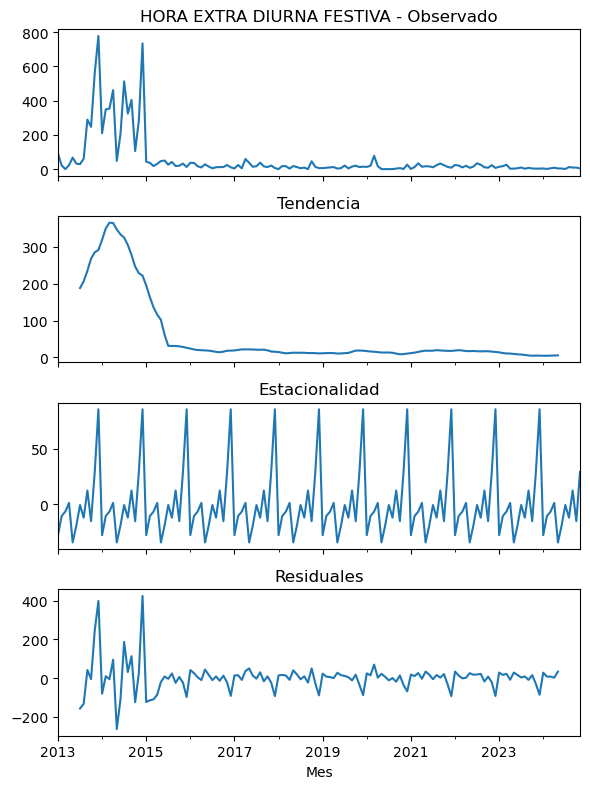


Analizando serie temporal para: HORA EXTRA DIURNA ORDINARIA


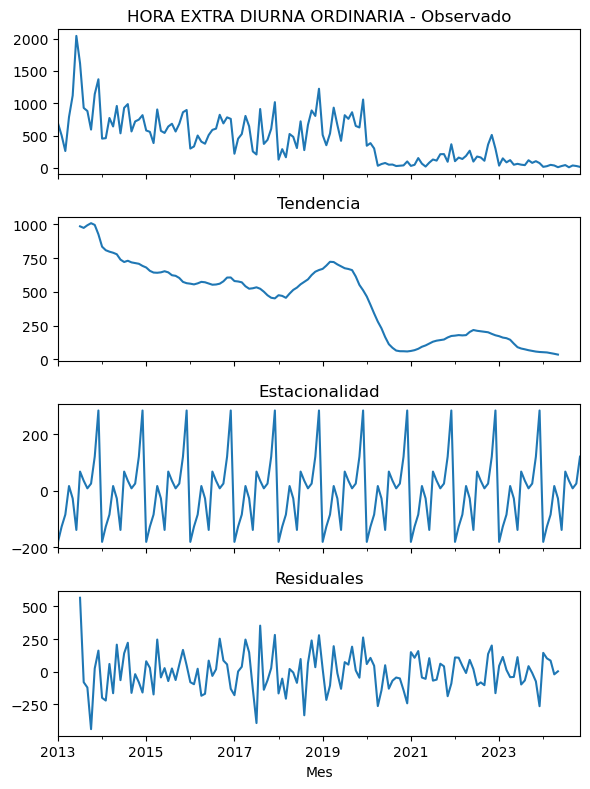


Analizando serie temporal para: HORA EXTRA NOCTURNA FESTIVA


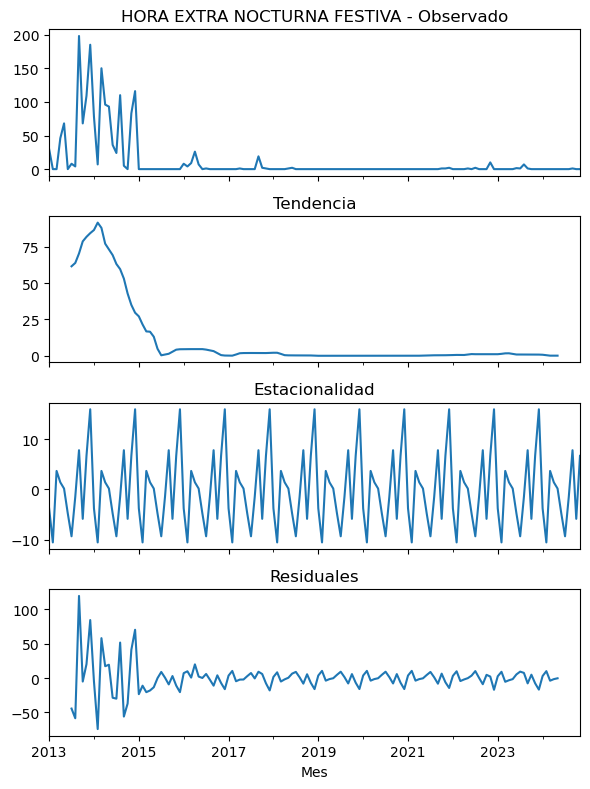


Analizando serie temporal para: HORA EXTRA NOCTURNA ORDINARIA


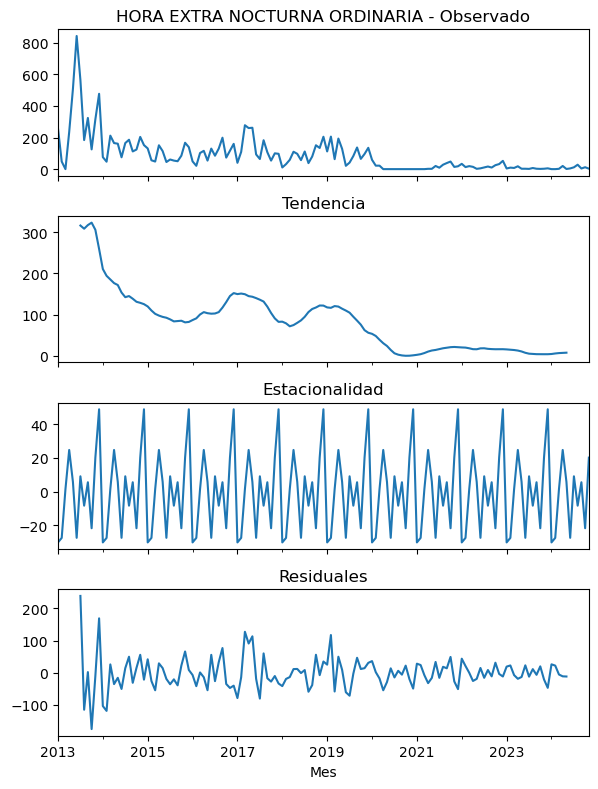

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Función para descomponer y graficar una serie temporal
def analizar_serie_temporal(df, concepto):
    try:
        # Filtrar datos del concepto
        data = df[['Mes', concepto]].dropna()
        data.set_index('Mes', inplace=True)

        # Realizar la descomposición aditiva
        descomposicion = seasonal_decompose(data[concepto], model='additive', period=12)

        # Graficar los componentes
        fig, ax = plt.subplots(4, 1, figsize=(6, 8), sharex=True)
        descomposicion.observed.plot(ax=ax[0], title=f"{concepto} - Observado")
        descomposicion.trend.plot(ax=ax[1], title="Tendencia")
        descomposicion.seasonal.plot(ax=ax[2], title="Estacionalidad")
        descomposicion.resid.plot(ax=ax[3], title="Residuales")

        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Error al analizar la serie temporal para {concepto}: {e}")

# Lista de conceptos relevantes
conceptos_relevantes = [
    'HORA EXTRA DIURNA FESTIVA',
    'HORA EXTRA DIURNA ORDINARIA',
    'HORA EXTRA NOCTURNA FESTIVA',
    'HORA EXTRA NOCTURNA ORDINARIA'
]

# Ejecutar el análisis para cada concepto
for concepto in conceptos_relevantes:
    print(f"\nAnalizando serie temporal para: {concepto}")
    analizar_serie_temporal(resumen_final, concepto)
